# Absolute Orientation implementation in Python
---

In [116]:
# import modules
import tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [138]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

axes = {'titlesize'  : '15',
        'labelsize'  : '12',
        'titleweight': 'bold',
        'labelweight': 'bold'}

matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)

### Absolute Orientation

In [110]:
# load trajectories
kinectTraj = np.loadtxt('kinect_trajectory', delimiter=',')
baxterTraj = np.loadtxt('baxter_trajectory', delimiter=',')

In [111]:
# get the trajectories
x = kinectTraj
y = baxterTraj

# number of samples
nSamples = x.shape[0]

# center data
xMean = x.mean(axis=0)
yMean = y.mean(axis=0)

xTemp = x - xMean
yTemp = y - yMean

# get the variance
xSD = np.mean(np.sum(xTemp**2, 1))
ySD = np.mean(np.sum(yTemp**2, 1))

# get covariance matrix
covarMatrix = np.dot(yTemp.T,xTemp) / nSamples

# apply singular value decomposition
U,D,V = np.linalg.svd(covarMatrix,full_matrices=True,compute_uv=True)
V=V.T.copy()

S = np.diag(np.asarray([1,1,np.sign(np.linalg.det(V)*np.linalg.det(U))]))

# get scaling factor
c = np.trace(np.dot(np.diag(D), S)) / xSD

# get rotation matrix
R = c*np.dot(np.dot(U,S), V.T)

# get translation vector
t = yMean - np.dot(R,xMean)

# compute transformation error
xOut = (np.dot(R,x.T)).T + t
errs = np.sqrt(np.sum((y - xOut)**2,axis=1))
err = errs.sum()/nSamples

print err

0.0144798132691


<IPython.core.display.Javascript object>


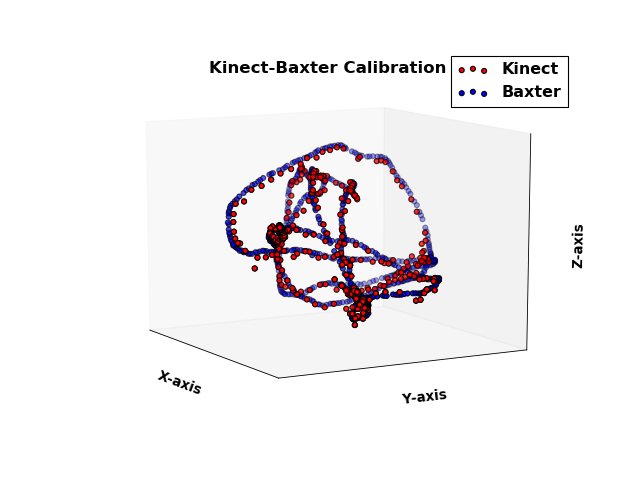

In [139]:
# plot both point sets together
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xHandle = Axes3D.scatter(ax,xOut[:,0],xOut[:,1],xOut[:,2],s=20,c='r')
yHandle = Axes3D.scatter(ax,y[:,0],y[:,1],y[:,2],s=20,c='b')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title('Kinect-Baxter Calibration')
plt.legend(['Kinect','Baxter'])
plt.show()

In [142]:
euler = tf.transformations.euler_from_matrix(R)
quat = tf.transformations.quaternion_from_euler(*euler)

print euler, quat

(-1.9976098042242243, 0.00865445832115714, 1.575813563544754) [-0.59471434 -0.59438474  0.38628395  0.37921806]


In [144]:
# save results to yaml file
f = open('kinect_calibration.yaml', 'w')
lines = ['trans: [', 'rot: [', 'rot_euler: [']

for elem in t: lines[0] += str(elem) + ', '
lines[0] += ']\n'
for elem in quat: lines[1] += str(elem) + ', '
lines[1] += ']\n'
for elem in euler: lines[2] += str(elem) + ', '
lines[2] += ']\n'

lines.append('parent: /base\n')
lines.append('child: /kinect2_link\n')

f.writelines(lines)
f.close()